In [1]:
from __future__ import division 
from pyomo.environ import * 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
m = AbstractModel('TFG_MMP_v2.0_July_2023')

In [3]:
m.G = Set()
m.p = Set()
m.s = Set() 
m.n = Set()
m.t = Set()
m.h = Set()
m.hf = Set()

In [4]:
data = DataPortal()
data.load(filename= 'g.csv', set= m.G)
data.load(filename= 'p.csv', set= m.p)
data.load(filename= 's.csv', set= m.s)
data.load(filename= 'n.csv', set= m.n)
data.load(filename= 't.csv', set= m.t)
data.load(filename= 'h.csv', set= m.h)
data.load(filename= 'hf.csv', set= m.hf)

In [5]:
m.e = 480

In [6]:

m.CO2rate = Param(m.G, within = NonNegativeReals)
m.alfa = Param(m.G, within = NonNegativeReals)
m.beta = Param(m.G, within = NonNegativeReals)
m.gamma = Param(m.G, within = NonNegativeReals)
m.f = Param(m.G, within = NonNegativeReals)
m.o = Param(m.G, within = NonNegativeReals)
m.qmax = Param(m.G, within = NonNegativeReals)
m.qmin = Param(m.G, within = NonNegativeReals)
m.bmax = Param(m.G, within = NonNegativeReals)
m.wmax = Param(m.G, within = NonNegativeReals)
m.w0 = Param(m.G, within = NonNegativeReals)
m.wmin = Param(m.G,within = NonNegativeReals)
m.k = Param(m.G, within = NonNegativeReals)
m.rend = Param(m.G, within = NonNegativeReals)

# Read CSV file into pandas DataFrame and convert to Pyomo parameter
param_data = pd.read_csv('Data_duration_demand1.csv', header=0, index_col=[0, 1, 2])
m.a = Param(m.n, m.s, m.p, initialize=param_data['a'].to_dict(), within = NonNegativeReals)
m.d = Param(m.n, m.s, m.p, initialize=param_data['d'].to_dict(), within = NonNegativeReals)

param_data2 = pd.read_csv('Data_inflows1.csv', header=0, index_col=[0, 1])
m.i = Param(m.h, m.p, initialize=param_data2['i'].to_dict(), within = NonNegativeReals)


param_data3 = pd.read_csv('Data_qred1.csv', header=0, index_col=[0, 1, 2, 3])
m.qred = Param(m.t, m.n, m.s, m.p, initialize=param_data3['qred'].to_dict(), within= NonNegativeReals)

data.load(filename="Data_generators1.csv", param=(m.CO2rate, m.alfa , m.beta , m.gamma , m.f , m.o , m.qmax , m.qmin , m.bmax , m.wmax , m.w0 , m.wmin , m.k , m.rend))
#instance = m.create_instance(data)
#instance.pprint()

In [7]:
m.u = Var(m.t, m.s, m.p,within= Binary) #u(t,s,p) Decision to connect generator g
m.y = Var(m.t,m.s, m.p, within= Binary)#y(t,s,p) Start up decision for generator g
m.z = Var(m.t, m.s, m.p, within= Binary)#z(t,s,p) Shut down decision for generator g 

In [8]:
m.qt = Var(m.t, m.n, m.s, m.p, within= NonNegativeReals) #q(t,n,s,p) Net power delivered by thermal generator t [GW]
m.qh = Var(m.h, m.n, m.s, m.p, within= NonNegativeReals) #q(h,n,s,p) Net power delivered by hydraulic generator h [GW]
m.b = Var(m.h, m.n, m.s, m.p, within= NonNegativeReals) #b(h,n,s,p)Gross power consumed by pumping-storage plant [GW]
m.w = Var(m.h, m.p, within= NonNegativeReals) #w(h,p) Hydroelectric energy in the reservoir of the plant [GWh]

In [9]:
def obj_rule (m):
    return sum((m.f[t]*(m.gamma[t]*m.y[t,s,p] + sum((m.a[n, s, p] * (m.alfa[t] * m.qt[t,n,s,p] / m.k [t] + m.beta[t] * m.u[t, s, p])) for n in m.n))  + 
        sum((m.a [n, s, p]* m.o[t] * m.qt[t, n, s, p] / m.k[t]) for n in m.n )) for t in m.t for p in m.p for s in m.s)

m.obj = Objective(rule= obj_rule, sense= minimize)

In [10]:

#DECLARATION OF CONSTRAINTS (meaning of warnings????) ## Very important the order
    #Demand balance and marginal cost
def Demand_Bal_rule(m,n,s,p): 
    return sum((m.qt[t,n,s,p]) for t in m.t) + sum((m.qh[h,n,s,p] - m.b[h,n,s,p]) for h in m.h) ==  m.d[n,s,p]

m.Demand_Bal = Constraint(m.n, m.s, m.p, rule= Demand_Bal_rule)

    #Upper thermal limit 
def Upper_Thermal_rule(m,t,n,s,p):
    return m.qt[t,n,s,p] <= m.u[t,s,p] * m.k[t] * m.qmax[t]

m.Upper_Thermal = Constraint(m.t, m.n, m.s, m.p, rule= Upper_Thermal_rule)
    #Upper hydro constraints
def Upper_Hydro_rule(m,h,n,s,p):
    return m.qh[h,n,s,p] <= m.k[h] * m.qmax[h]

m.Upper_Hydro = Constraint(m.h, m.n, m.s, m.p, rule= Upper_Hydro_rule)
    #Maximum Capacity limits for pumped storage
def Upper_Pumping_rule(m,h,n,s,p):
    return m.b[h,n,s,p] <= m.k[h] * m.bmax[h]

m.Upper_Pumping_Hydro = Constraint(m.h, m.n, m.s, m.p, rule= Upper_Pumping_rule)
    #Lower thermal limit
def Lower_Thermal_rule(m,t,n,s,p):
    return m.qt[t,n,s,p] >= m.u[t,s,p] * m.k[t] * m.qmin[t]

m.Lower_Thermal = Constraint(m.t, m.n, m.s, m.p, rule= Lower_Thermal_rule)
    #Energy balance in an equivalent reservoir
def E_Bal_rule(m,h,p):
    if p == m.p.first() and h == 'HYDRO_RES':
         return m.w[h,p] + sum(m.a[n,s,p] * (m.qh[h,n,s,p]/m.k[h] - m.rend[h] * m.b[h,n,s,p]) for n in m.n for s in m.s) <= 1200 + m.i[h,p]
    elif p == m.p.first():
         return m.w[h,p] + sum(m.a[n,s,p] * (m.qh[h,n,s,p]/m.k[h] - m.rend[h] * m.b[h,n,s,p]) for n in m.n for s in m.s) <= m.i[h,p]
    else:
        return m.w[h,p] + sum(m.a[n,s,p] * (m.qh[h,n,s,p]/m.k[h] - m.rend[h] * m.b[h,n,s,p]) for n in m.n for s in m.s) <= m.w[h,int(p) - 1] + m.i[h,p]

m.E_Bal = Constraint(m.h, m.p, rule= E_Bal_rule)
    #Upper limit equivalent energy stored in reservoir
def Upper_W_rule(m,h,p):
    return m.w[h,p] <= m.wmax[h]

m.Upper_W = Constraint(m.h, m.p, rule = Upper_W_rule)
    #Lower limit equivalent energy stored in basin
def Lower_W_rule(m,h,p):
    return m.w[h,p] >= m.wmin[h]

m.Lower_W = Constraint(m.h, m.p, rule = Lower_W_rule)
    #Minimum operating hours for thermal group during the year
def Min_H_t_rule(m,t):
    return sum((m.a[n,s,p] * m.qt[t,n,s,p]) for n in m.n for s in m.s for p in m.p) >= m.k[t] * m.qmax[t] * m.e

m.Min_H_t = Constraint(m.t, rule = Min_H_t_rule)


 #Minimum operating hours for hidraulic group during the year
def Min_H_h_rule(m,h):
    return sum((m.a[n,s,p] * m.qh[h,n,s,p]) for n in m.n for s in m.s for p in m.p) >= m.k[h] * m.qmax[h] * m.e

m.Min_H_h = Constraint(m.h, rule = Min_H_h_rule)

    #Minimum production to accommodate grid constraints
def Min_Grid_rule(m,t,n,s,p):
    return m.qt[t,n,s,p] >= m.qred[t,n,s,p]

m.Min_Grid = Constraint(m.t, m.n, m.s, m.p, rule = Min_Grid_rule)

    #Constraint for intra-period changes
def Intrap_changes_rule(m,t,p):
    return m.u[t,'fes',p] - m.u[t,'lab',p] == m.y[t,'fes',p] - m.z[t,'fes',p]

m.Intrap_changes = Constraint(m.t, m.p, rule= Intrap_changes_rule)
    
    #Constraint for inter-period transition
def Intrap_transitions_rule(m,t,p):
    if p == m.p.first():
        return Constraint.Skip
    else:
        return  m.u[t,'lab',p] - m.u[t,'fes',int(p) - 1] == m.y[t,'lab',p] - m.z[t,'lab',p]

m.Intrap_transitions = Constraint(m.t, m.p, rule= Intrap_transitions_rule)

'''
def Fix_run_river_rule (m,h,n,s,p):
    return m.qh[h,n,s,p] == m.i[h,p]/sum(m.a[n,s,p] for n in m.n for s in m.s)

m.Fix_run_river_rule = Constraint (m.h,m.n, m.s, m.p, rule= Fix_run_river_rule)
'''





'\ndef Fix_run_river_rule (m,h,n,s,p):\n    return m.qh[h,n,s,p] == m.i[h,p]/sum(m.a[n,s,p] for n in m.n for s in m.s)\n\nm.Fix_run_river_rule = Constraint (m.h,m.n, m.s, m.p, rule= Fix_run_river_rule)\n'

In [11]:
m.dual = Suffix(direction=Suffix.IMPORT, datatype= None)

In [12]:
print(data['G'],'\n')
print(data['p'],'\n')
print(data['s'],'\n')
print(data['n'],'\n')
print(data['t'],'\n')
print(data['h'],'\n')
print(data['hf'],'\n')
print(type(data['p'][10]))

['GEN_001', 'GEN_002', 'GEN_003', 'GEN_004', 'GEN_005', 'GEN_006', 'GEN_007', 'GEN_008', 'HYDRO_RES', 'HYDRO_ROR', 'HYDRO_PUM'] 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 

['lab', 'fes'] 

['n1', 'n2', 'n3', 'n4', 'n5'] 

['GEN_001', 'GEN_002', 'GEN_003', 'GEN_004', 'GEN_005', 'GEN_006', 'GEN_007', 'GEN_008'] 

['HYDRO_RES', 'HYDRO_ROR', 'HYDRO_PUM'] 

['HYDRO_ROR'] 

<class 'int'>


In [13]:
instance = m.create_instance(data)
#instance.pprint()

In [14]:
solver = SolverFactory('gurobi')

In [15]:
solver.options['Method'           ] =    1                                       # Solution method: dual-simplex {1} o barrier {2}
solver.options['MIPGap'           ] =    0.00                                    # Optcr
solver.options['Threads'          ] =    7                                       # Number of cores dedicated to the optimization
solver.options['IntFeasTol'       ] = 1e-9
solver.options['OptimalityTol'    ] = 1e-9
solver.options['FeasibilityTol'   ] = 1e-9
solver.options['RINS'             ] =  100
solver.options['DisplayInterval'  ] =   30
solver.options['NumericFocus'     ] =    3
solver.options['MarkowitzTol'     ] =    0.999
solver.options['ScaleFlag'        ] =    2

In [16]:

results = solver.solve(instance)
#instance.pprint() #PYOMO WORKS IN ALPHABETICAL ORDER
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2293
  Lower bound: 525017.7725821971
  Upper bound: 525017.7725821971
  Number of objectives: 1
  Number of constraints: 4024
  Number of variables: 2284
  Number of binary variables: 567
  Number of integer variables: 567
  Number of continuous variables: 1717
  Number of nonzeros: 9686
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message:

In [17]:

#results.write()

In [18]:
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
    instance.write('MMP.lp',io_options={'symbolic_solver_labels': True})
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  result.solver.status)

feasible


In [19]:
print('OBJ=',round(value(instance.obj),2))

OBJ= 525017.77


In [20]:
#FIXING BINARY VARIABLES TO DISPLAY DUAL VARIABLES

if results.solver.termination_condition == TerminationCondition.optimal:
    # Fix binary variable to its optimal value
    for t in instance.t:
        for s in instance.s:
            for p in instance.p:
                instance.y[t,s, p].fix(instance.y[t, s,p].value)
    for t in instance.t:
        for n in instance.n:
            for s in instance.s:
                for p in instance.p:
                    instance.u[t,s,p].fix(instance.u[t,s,p].value)
    for t in instance.t:
        for n in instance.n:
            for s in instance.s:
                for p in instance.p:
                    instance.z[t,s,p].fix(instance.z[t,s,p].value)
    
    
    
    # Solve the model again
    result = solver.solve(instance)  # Solve the model with fixed binary variables
    
    # Check the new solution
    if result.solver.termination_condition == TerminationCondition.optimal:
        # Access the updated objective value
        updated_objective_value = instance.obj.expr()  # Updated objective value
        print("Updated objective value:", updated_objective_value)
    else:
        print("The model did not reach an optimal solution after fixing the binary variables.")
else:
    print("The model did not reach an optimal solution.")
    
#instance.dual.display()      

Updated objective value: 525017.7725821966


# STACKED PRODUCTION BY TECHNOLOGY (thermal and hydraulic)

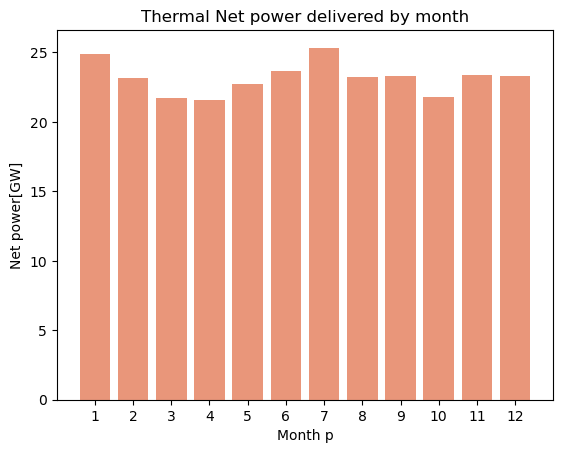

In [21]:

fig, ax = plt.subplots()
x_values = range(1, len(instance.p) + 1)
for p in instance.p:
    [ax.bar(p, value(sum(instance.qt[t, n, s, p] for s in instance.s for n in instance.n for t in instance.t)), color = 'darksalmon')]
ax.set_xticks(x_values)
ax.set_xlabel("Month p")
ax.set_ylabel("Net power[GW]")
ax.set_title("Thermal Net power delivered by month")
plt.show()

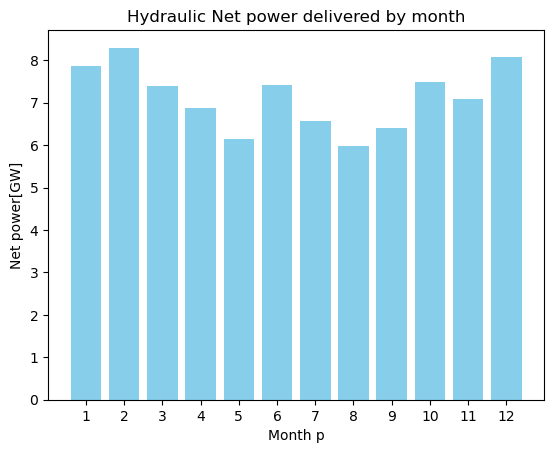

In [22]:
fig2, ax2 = plt.subplots()
x_values = range(1, len(instance.p) + 1)
for p in instance.p:
    [ax2.bar(p, value(sum(instance.qh[h, n, s, p] for s in instance.s for n in instance.n for h in instance.h)), color = 'skyblue')]
ax2.set_xticks(x_values)
ax2.set_xlabel("Month p")
ax2.set_ylabel("Net power[GW]")
ax2.set_title("Hydraulic Net power delivered by month")
plt.show()

**STARTING WITH MATPLOTLIB:**

When we call plt.subplot() function we unpack a tuple with 2 values:

    - Figure: You can reshape it, but not draw on it
    - Axes: The coordinate system (i.e the canvas you draw on)

For more info check out : https://towardsdatascience.com/clearing-the-confusion-once-and-for-all-fig-ax-plt-subplots-b122bb7783ca

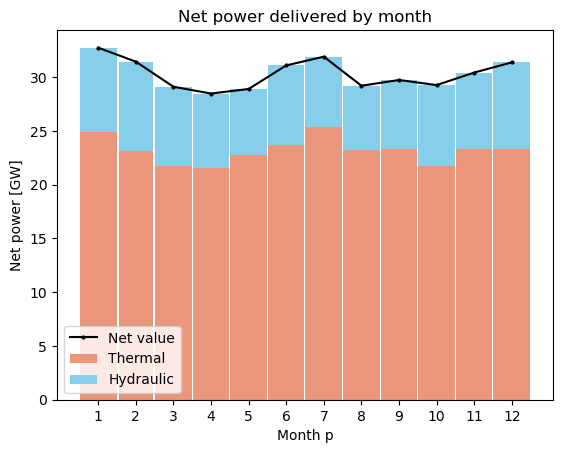

In [23]:
#month_dict =('January', 'February','March','April','May','June','July','August','September'
                #'October', 'November', 'December')

values1 = []
values2 = []
awidth = []
fig3,ax3 = plt.subplots()
x_values = range(1, len(instance.p) + 1)
for p in instance.p:
    values1.append(value(sum(instance.qt[t, n, s, p] for s in instance.s for n in instance.n for t in instance.t)))
    values2.append(value(sum(instance.qh[h, n, s, p] for s in instance.s for n in instance.n for h in instance.h)))
    awidth.append(value(sum(instance.a[n, s, p] for s in instance.s for n in instance.n)))
    ax3.bar(p, values1[p - 1], width = awidth[p - 1] / 750,color='darksalmon')
    if values2 [p - 1] >= 0:
        ax3.bar(p, values2[p - 1], bottom = values1[p - 1], width = awidth[p - 1] / 750, color='skyblue')
    else: #Because we have negative values, the bottom needs to be set to zero to avoid overlapping
        ax3.bar(p, values2[p - 1],width = awidth[p - 1] / 750, color = 'skyblue')
    #print("value thermal", p, ":", values1[p - 1])
    #print("value hydraulic", p, ":", values2[p - 1])
    #print("hours of work in month", p,":", awidth[p - 1])

#values3 = []
#values3 = [(values1[p - 1] + values2[p - 1]) for p in instance.p]
plt.plot(instance.p, list(map(lambda p: values1[p - 1] + values2[p - 1], instance.p))
, color = 'black', marker= 'o', markersize= '2')
#print(map(lambda p: values1[p - 1] + values2[p - 1], instance.p))

# Customizing the chart
ax3.set_xticks(x_values)
ax3.set_xlabel("Month p")
ax3.set_ylabel("Net power [GW]")
ax3.set_title("Net power delivered by month")
ax3.legend(['Net value', 'Thermal', 'Hydraulic'])

# Displaying the chart
plt.show()
    

In [24]:
print(instance.s.at(1))

lab


In [25]:
#Create multindex dataframe
arrays = []
aux = []
for i in range(1,len(instance.s) + 1):
    if i == 1:
        aux = [instance.s.at(i) for j in range(1,len(instance.n) + 1)]
        arrays.append(aux)
    else:
        aux = [instance.s.at(i) for j in range(1,len(instance.n) + 1)]
        arrays[i - 2].extend(aux)
for k in range(1, len(instance.s) + 1):
    aux = [instance.n.at(l) for l in range(1,len(instance.n) + 1)]
    if k == 1:
        arrays.append(aux)
    else: 
        arrays[len(instance.s) - 1].extend(aux)
print(arrays)

[['lab', 'lab', 'lab', 'lab', 'lab', 'fes', 'fes', 'fes', 'fes', 'fes'], ['n1', 'n2', 'n3', 'n4', 'n5', 'n1', 'n2', 'n3', 'n4', 'n5']]


In [26]:
index = pd.MultiIndex.from_tuples(list(zip(*arrays)))
#print(index)
#print(list(zip(*arrays)))

In [27]:
data_array= [10.0]
#t,h -> n-> s -> p
for s in instance.s:
    for n in instance.n:
        values1 = value(sum(instance.qt[t, n, s, 1] for t in instance.t))
        data_array.append(values1)
        #print("values thermal ",values1, " at level ",n,"in week ",s)
for s in instance.s:
    for n in instance.n:       
        values2 = value(sum(instance.qh[h, n, s, 1] for h in instance.h))
        data_array.append(values2)
        #print("values hydraulic ",values2, " at level ",n,"in week ",s)

        
data_array.remove(10.0)
#print(data_array)
my_array = np.array(data_array)

resized_array = my_array.reshape(2,10)
print(resized_array)

[[3.7218     3.7218     3.4        3.34123552 3.1202     1.8148
  1.8148     1.8148     1.8148     0.3       ]
 [0.9782     0.5782     0.5        0.08108108 0.         2.0852
  1.5852     1.1852     0.8852     0.        ]]


      lab                                    fes                             
       n1      n2   n3        n4      n5      n1      n2      n3      n4   n5
0  3.7218  3.7218  3.4  3.341236  3.1202  1.8148  1.8148  1.8148  1.8148  0.3
1  0.9782  0.5782  0.5  0.081081  0.0000  2.0852  1.5852  1.1852  0.8852  0.0


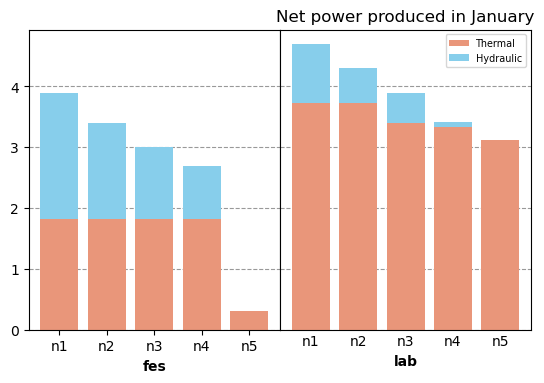

In [28]:
df = pd.DataFrame(data=resized_array ,columns= index)
print(df)
#print(df.columns.levels[0])
#print(df.columns.levels[1])
#Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, sharey= True, figsize= (14 / 2.54, 10 / 2.54))
for i, col in enumerate(df.columns.levels[0]):
    #print(col)
    #print(i)
    ax = axes[i]
    df[col].T.plot(ax=ax, kind='bar',stacked= True, width=.8, color=['darksalmon','skyblue'])
    

    ax.legend_.remove()
    ax.set_xlabel(col, weight='bold')
    ax.yaxis.grid(visible=True, which='major', color='black', linestyle='--', alpha=.4)
    ax.set_axisbelow(True)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

#make the ticklines invisible
ax.tick_params(axis=u'both', which=u'both', length=0)
ax.set_title("Net power produced in January")
plt.tight_layout()
# remove spacing in between
fig.subplots_adjust(wspace=0)  # space between plots
ax.legend(['Thermal', 'Hydraulic'], fontsize= 'x-small')
plt.show()

In [29]:
#Create multindex dataframe
arrays = []
aux = []

for p in instance.p:
    if p == 1:
        aux = [instance.p.at(1) for j in range(1, len(instance.p) - 1)]
        arrays.append(aux)
        aux=[]
    else:
        aux = [instance.p.at(p) for j in range(1, len(instance.p) - 1)]
        arrays[0].extend(aux)
for p in instance.p:           
    for i in range(1,len(instance.s) + 1):
        if i == 1 and p == 1:
            aux = [instance.s.at(i) for j in range(1,len(instance.n) + 1)]
            arrays.append(aux)
        else:
            aux = [instance.s.at(i) for j in range(1,len(instance.n) + 1)]
            arrays[1].extend(aux)
for p in instance.p:
    for k in range(1, len(instance.s) + 1):
        aux = [instance.n.at(l) for l in range(1,len(instance.n) + 1)]
        if k == 1 and p == 1:
            arrays.append(aux)
        else: 
            arrays[2].extend(aux)

    
#print(arrays)

In [30]:
index = pd.MultiIndex.from_tuples(list(zip(*arrays)))
#print(index)
#print(list(zip(*arrays)))

In [31]:
data_array= [10.0]
for p in instance.p:
    for s in instance.s:
        for n in instance.n:
            values1 = value(sum(instance.qt[t, n, s, p] for t in instance.t))
            data_array.append(values1)
            #print("values thermal ",values1, " at level ",n,"in week ",s)
for p in instance.p:
    for s in instance.s:
        for n in instance.n:       
            values2 = value(sum(instance.qh[h, n, s, p] for h in instance.h))
            data_array.append(values2)
            #print("values hydraulic ",values2, " at level ",n,"in week ",s)

data_array.remove(10.0)
#print(data_array)
my_array = np.array(data_array)

resized_array = my_array.reshape(2,120)
#print(resized_array)

       1                                                                       \
      lab                                    fes                                
       n1      n2   n3        n4      n5      n1      n2      n3      n4   n5   
0  3.7218  3.7218  3.4  3.341236  3.1202  1.8148  1.8148  1.8148  1.8148  0.3   
1  0.9782  0.5782  0.5  0.081081  0.0000  2.0852  1.5852  1.1852  0.8852  0.0   

   ...      12                                                          \
   ...     lab                                     fes                   
   ...      n1      n2      n3      n4      n5      n1      n2      n3   
0  ...  3.2142  3.2142  3.2142  3.2023  2.8825  1.8148  1.8148  1.8148   
1  ...  1.4358  1.0188  0.6079  0.0000  0.0000  1.9040  1.4852  0.9743   

                
                
       n4   n5  
0  1.8148  0.3  
1  0.6644  0.0  

[2 rows x 120 columns]
Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')
Index(['fes', 'lab'], dtype='object')
Index(['n

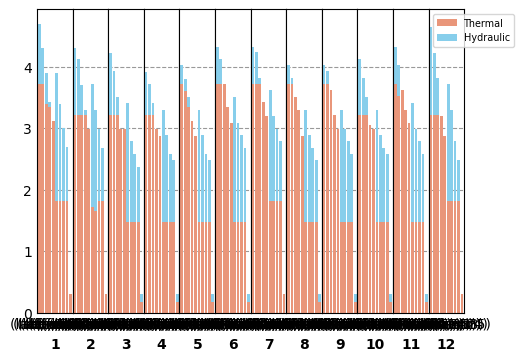

In [32]:
df = pd.DataFrame(data=resized_array ,columns= index)
print(df)
print(df.columns.levels[0])
print(df.columns.levels[1])
print(df.columns.levels[2])
#Plotting
fig, axes = plt.subplots(nrows=1, ncols=12, sharey= True, figsize= (14 / 2.54, 10 / 2.54))
for i, col in enumerate(df.columns.levels[0]):
    #print(col)
    #print(i)
    ax = axes[i]
    df[col].T.plot(ax=ax, kind='bar',stacked= True, width=.8, color=['darksalmon','skyblue'])
    

    ax.legend_.remove()
    ax.set_xlabel(col, weight='bold')
    ax.yaxis.grid(visible=True, which='major', color='black', linestyle='--', alpha=.4)
    ax.set_axisbelow(True)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

    #make the ticklines invisible
    ax.tick_params(axis=u'both', which=u'both', length=0)
#ax.set_title("Net power produced in January")
#plt.tight_layout()
# remove spacing in between
fig.subplots_adjust(wspace=0)  # space between plots
ax.legend(['Thermal', 'Hydraulic'], fontsize= 'x-small')
plt.show()

# MARGINAL COSTS OF THE SYSTEM

Dual variable associated to marginal cost example: 459.5744680851064


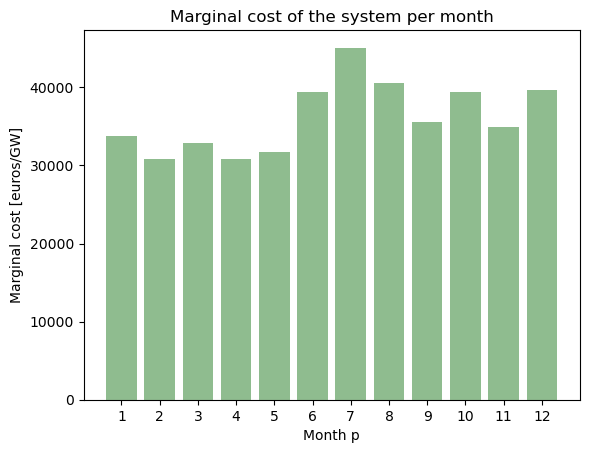

In [33]:
shadow_price = instance.dual[instance.Demand_Bal['n1','lab',1]]
print("Dual variable associated to marginal cost example:",shadow_price)


fig5, ax5 = plt.subplots()
x_values = range(1, len(instance.p) + 1)
for p in instance.p:
    [ax5.bar(p, value(sum(instance.dual[instance.Demand_Bal[n, s, p]] for s in instance.s for n in instance.n)), color = 'darkseagreen')]
ax5.set_xticks(x_values)
ax5.set_xlabel("Month p")
ax5.set_ylabel("Marginal cost [euros/GW]")
ax5.set_title("Marginal cost of the system per month")
plt.show()
            

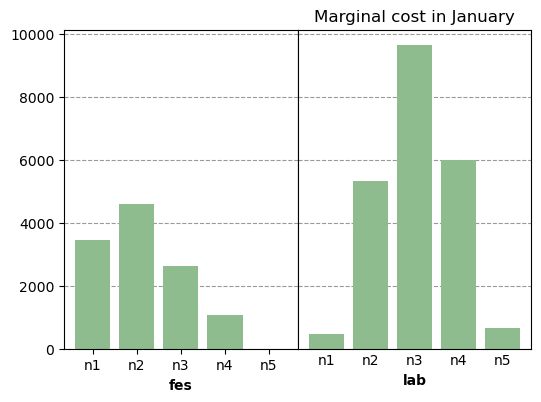

In [34]:
data_array= [10.0]
for s in instance.s:
    for n in instance.n:
        values3 = value(instance.dual[instance.Demand_Bal[n, s, 1]])
        data_array.append(values3)
        
data_array.remove(10.0)
my_array = np.array(data_array)

resized_array = my_array.reshape(1,10)

#Create multindex dataframe
arrays = []
aux = []
for i in range(1,len(instance.s) + 1):
    if i == 1:
        aux = [instance.s.at(i) for j in range(1,len(instance.n) + 1)]
        arrays.append(aux)
    else:
        aux = [instance.s.at(i) for j in range(1,len(instance.n) + 1)]
        arrays[i - 2].extend(aux)
for k in range(1, len(instance.s) + 1):
    aux = [instance.n.at(l) for l in range(1,len(instance.n) + 1)]
    if k == 1:
        arrays.append(aux)
    else: 
        arrays[len(instance.s) - 1].extend(aux)

index = pd.MultiIndex.from_tuples(list(zip(*arrays)))

df = pd.DataFrame(data=resized_array ,columns= index)


fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14 / 2.54, 10 / 2.54))  # width, height
for i, col in enumerate(df.columns.levels[0]):
    ax = axes[i]
    df[col].T.plot(ax=ax, kind='bar', width=.8, color='darkseagreen')

    ax.legend_.remove()
    ax.set_xlabel(col, weight='bold')
    ax.yaxis.grid(visible=True, which='major', color='black', linestyle='--', alpha=.4)
    ax.set_axisbelow(True)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
#make the ticklines invisible
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()
# remove spacing in between
fig.subplots_adjust(wspace=0)  # space between plots

ax.set_title("Marginal cost in January")

plt.show()

# EVOLUTION OF THE RESERVES OF THE HYDRO PLANTS

[1339.9936  1364.65102 1384.95062 1400.      1400.      1325.748
 1213.254   1000.      1050.767   1015.7004  1043.4422  1000.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.     ]
2
3
final arrays [['HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]


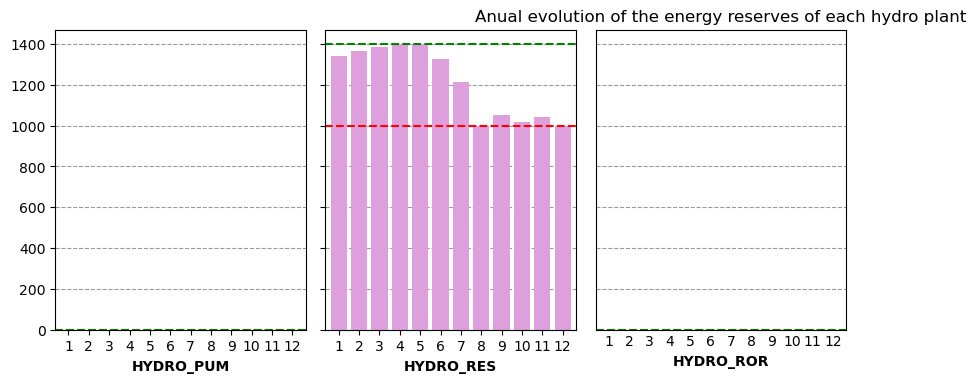

In [35]:
data_array= [10.0]
for h in instance.h:
    for p in instance.p:
        values3 = value(instance.w[h,p]) #+ value(instance.w0[h]) #No olvidarse del valor inicial
        data_array.append(values3)
        
data_array.remove(10.0)
my_array = np.array(data_array)
print(my_array)

resized_array = my_array.reshape(1,36)

#Create multindex dataframe
arrays = []
aux = []

for k in range(1, len(instance.h) + 1):
    aux = [instance.h.at(k) for l in range(1,len(instance.p) + 1)]
    if k == 1:
        arrays.append(aux)
        #print(arrays)
    else: 
        arrays[0].extend(aux)
for i in range(1,len(instance.h) + 1):
    if i == 1:
        aux = [instance.p.at(j) for j in range(1,len(instance.p) + 1)]
        arrays.append(aux)
        #print(arrays)
    else:
        print(i)
        aux = [instance.p.at(j) for j in range(1,len(instance.p) + 1)]
        arrays[1].extend(aux)
        #print(arrays)

print("final arrays",arrays)

index = pd.MultiIndex.from_tuples(list(zip(*arrays)))

df = pd.DataFrame(data=resized_array,columns= index)


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(22 / 2.54, 10 / 2.54))  # width, height
for i, col in enumerate(df.columns.levels[0]):
    if i == 0:
        word = 'HYDRO_PUM'
    elif i == 1:
        word = 'HYDRO_RES'
    else:
        word = 'HYDRO_ROR'
    ax = axes[i]
    df[col].T.plot(ax=ax, kind='bar', width=.8, color='plum')

    ax.legend_.remove()
    ax.set_xlabel(col, weight='bold')
    ax.yaxis.grid(visible=True, which='major', color='black', linestyle='--', alpha=.4)
    ax.set_axisbelow(True)
    ax.axhline(instance.wmin[word], color='r', linestyle='--')
    ax.axhline(instance.wmax[word], color='g', linestyle='--')

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
#make the ticklines invisible
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()
# remove spacing in between
fig.subplots_adjust(wspace=0)  # space between plots

ax.set_title("Anual evolution of the energy reserves of each hydro plant")
plt.tight_layout()
plt.show()



# EVOLUTION OF THE MARGINAL VALUE OF WATER OF EACH HYDRO PLANT

[-45.95744681 -45.95744681 -45.95744681 -45.95744681 -45.95744681
 -65.65349544 -65.65349544 -65.65349544 -57.75075988 -57.75075988
 -57.75075988 -57.75075988 -40.42553191 -45.95744681 -45.95744681
 -45.95744681 -45.95744681 -65.65349544 -65.65349544 -65.65349544
 -57.75075988 -57.75075988 -45.95744681 -57.75075988 -57.75075988
 -45.95744681 -45.95744681 -45.95744681 -45.95744681 -65.65349544
 -65.65349544 -65.65349544 -57.75075988 -57.75075988 -57.75075988
 -57.75075988]
2
3
final arrays [['HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_RES', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_ROR', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM', 'HYDRO_PUM'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,

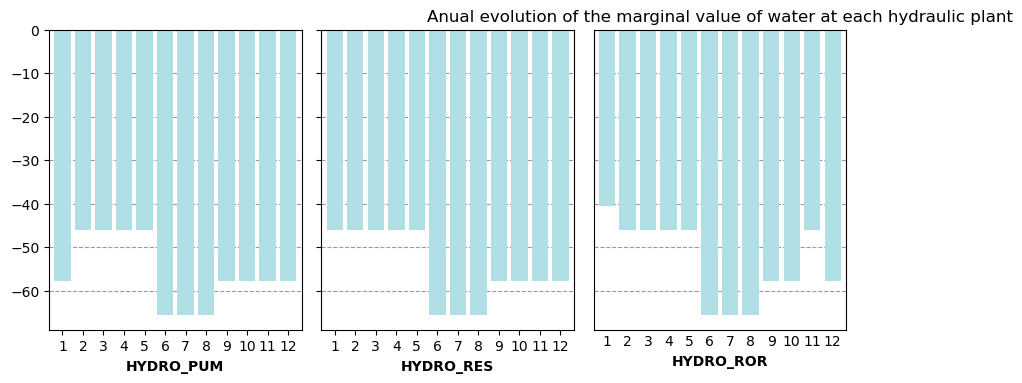

In [36]:
data_array= [10.0]
for h in instance.h:
    for p in instance.p:
        values3 = value(instance.dual[instance.E_Bal[h,p]])
        data_array.append(values3)
        
data_array.remove(10.0)
my_array = np.array(data_array)
print(my_array)

resized_array = my_array.reshape(1,36)

#Create multindex dataframe
arrays = []
aux = []

for k in range(1, len(instance.h) + 1):
    aux = [instance.h.at(k) for l in range(1,len(instance.p) + 1)]
    if k == 1:
        arrays.append(aux)
        #print(arrays)
    else: 
        arrays[0].extend(aux)
for i in range(1,len(instance.h) + 1):
    if i == 1:
        aux = [instance.p.at(j) for j in range(1,len(instance.p) + 1)]
        arrays.append(aux)
        #print(arrays)
    else:
        print(i)
        aux = [instance.p.at(j) for j in range(1,len(instance.p) + 1)]
        arrays[1].extend(aux)
        #print(arrays)

print("final arrays",arrays)

index = pd.MultiIndex.from_tuples(list(zip(*arrays)))

df = pd.DataFrame(data=resized_array,columns= index)


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(22 / 2.54, 10 / 2.54))  # width, height
for i, col in enumerate(df.columns.levels[0]):
    ax = axes[i]
    df[col].T.plot(ax=ax, kind='bar', width=.8, color='powderblue')

    ax.legend_.remove()
    ax.set_xlabel(col, weight='bold')
    ax.yaxis.grid(visible=True, which='major', color='black', linestyle='--', alpha=.4)
    ax.set_axisbelow(True)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
#make the ticklines invisible
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.tight_layout()
# remove spacing in between
fig.subplots_adjust(wspace=0)  # space between plots

ax.set_title("Anual evolution of the marginal value of water at each hydraulic plant")
plt.tight_layout()
plt.show()